# Data Visualization Notebook

**Make sure that you have run data_collection.ipynb before running this one.**

## Objectives

- Address business requiremenent 1:
    - The client is interested in conducting a study to visually differentiate a cherry leaf that is healthy from one that contains powdery mildew.

## Inputs

This notebook will use the following inputs:
- inputs/cherry-leaves/cherry-leaves/test
- inputs/cherry-leaves/cherry-leaves/train
- inputs/cherry-leaves/cherry-leaves/validation

## Outputs

This notebook will generate the following outputs:
- A pickle file storing image shape embeddings (image data stored as a numercal representation) 
- Plots that show the mean (average) image and variability of images for each label
- A plot to show the difference beween healthy leaves and mildewed leaves
- Code to address business requirement 1 and build an image montage

## Import Packages

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import random
sns.set_style("white")
from pathlib import Path
from matplotlib.image import imread
from PIL import Image
from tensorflow.keras.preprocessing import image

## Change working directory

By default, the working directory is "jupyter_notebooks", where the notebook is running. However, we need to change the working directory to its parent folder so that file references align with the broader project structure.

To do this, we first check the current working directory — note that the output below only displays the last two folders in the file path, rather than the full system path. This is done intentionally to prevent exposing the full local file path stored on my machine.

**Any time you revisit this notebook after logging out, or open a different notebook for the first time, you must repeat these steps to ensure the working directory is always correctly set.**

In [2]:
import os
from pathlib import Path # ensure file path consistency

# Get the current working directory
current_dir = Path.cwd()

# Extract the last two directory names
filtered_path = Path(*current_dir.parts[-2:])
print(f"📂 {filtered_path}")  # Example output: 📂 mildew_detector/jupyter_notebooks

📂 mildew_detector\jupyter_notebooks


Now we change the working directory from "jupyter_notebooks" to the parent directory.

In [3]:
# Change the working directory to its parent folder
os.chdir(os.path.dirname(os.getcwd()))

# Confirmation message with
print("✅ You set a new current directory")

✅ You set a new current directory


Confirm the new current directory.

In [4]:
# Get the current working directory
current_dir = Path.cwd()

# Extract the last two directory names
filtered_path = Path(*current_dir.parts[-2:])
print(f"📂 {filtered_path}")  # Example output: 📂 mildew_detector/jupyter_notebooks

📂 Projects\mildew_detector


## Set the Input Directories

Now we need to define the paths where this notebook will find the data we'll be using.

In [5]:
# Define base image data path
image_data = Path("inputs") / "cherry-leaves" / "cherry-leaves"

# Define paths for train, validation, and test sets
train_path = image_data / "train"
val_path = image_data / "validation"
test_path = image_data / "test"

# Print paths
print(f"📂 Train Path: {train_path}")
print(f"📂 Validation Path: {val_path}")
print(f"📂 Test Path: {test_path}")

📂 Train Path: inputs\cherry-leaves\cherry-leaves\train
📂 Validation Path: inputs\cherry-leaves\cherry-leaves\validation
📂 Test Path: inputs\cherry-leaves\cherry-leaves\test


### Confrim that the file paths are valid

Now we'll run a function just to check that the file paths defined above are valid.

The function will select one image from each train, test and validation folder and display it below along with the file path beginning with the "inputs" folder.

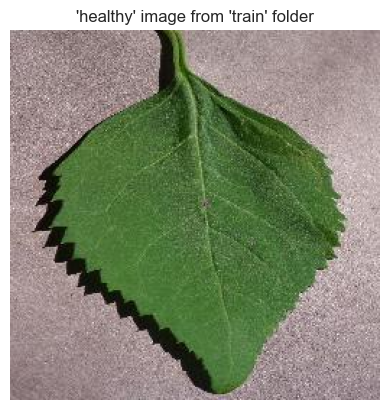

✅ random train image: inputs\cherry-leaves\cherry-leaves\train\healthy\e37c34a3-b8d4-4fbd-b7a7-f0b14e4bb090___JR_HL 4294_180deg.JPG


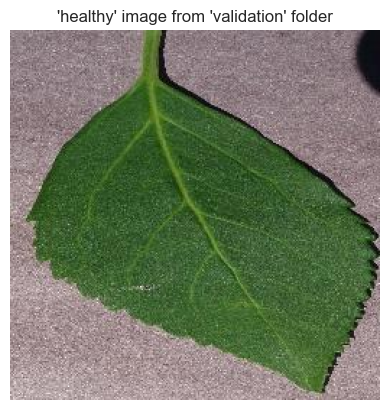

✅ random validation image: inputs\cherry-leaves\cherry-leaves\validation\healthy\a57b87e2-574d-401a-aa1e-6ce2a1339599___JR_HL 4319_flipTB.JPG


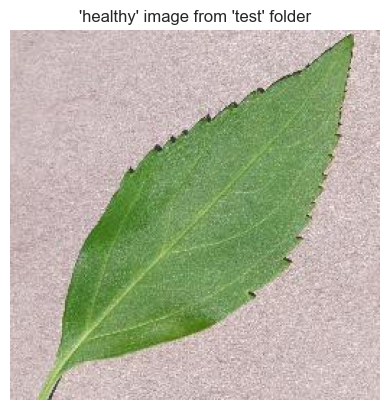

✅ random test image: inputs\cherry-leaves\cherry-leaves\test\healthy\0ce4ee15-d59b-4212-ab2a-8b6a07f3634f___JR_HL 9707.JPG


In [6]:
from pathlib import Path

# Function to find and display a random image from subfolders
def show_random_image(parent_folder):
    """
    Selects and displays a random image from a subfolder inside the given parent directory.

    Args:
        parent_folder (str or Path): The path to the main dataset folder (e.g., train, validation, test).

    Returns:
        str or None: The full path to the randomly selected image, or None if no images are found.
    """

    parent_folder = Path(parent_folder)  # Ensure it's a Path object

    # Ensure the parent folder exists
    if not parent_folder.exists():
        print(f"❌ path does not exist: {parent_folder}")
        return None

    # Scan subdirectories ('healthy', 'powdery_mildew')
    subfolders = [f for f in parent_folder.iterdir() if f.is_dir()]

    if not subfolders:
        print(f"⚠️ no subfolders found in: {parent_folder}")
        return None

    # Pick a random subfolder (class name)
    chosen_folder = random.choice(subfolders)

    # Find image files inside that subfolder
    image_files = [f for f in chosen_folder.iterdir() if f.suffix.lower() in {'.png', '.jpg', '.jpeg', '.bmp', '.webp'}]

    if not image_files:
        print(f"⚠️ no images found in: {chosen_folder}")
        return None

    # Select a random image and display it
    chosen_image = random.choice(image_files)

    # Load image using PIL
    image = Image.open(chosen_image)

    # Extract folder name ('healthy'/'powdery_mildew') and dataset section ('train'/'validation'/'test')
    class_name = chosen_folder.name
    dataset_section = parent_folder.name

    # Display the image with correct labeling
    plt.imshow(image)
    plt.title(f"'{class_name}' image from '{dataset_section}' folder")
    plt.axis("off")  # Hide axes for a cleaner look
    plt.show()

    return str(chosen_image)  # Return path for confirmation

# Fetch and display random images from each dataset section
train_image = show_random_image(train_path)
print(f"✅ random train image: {train_image}")

val_image = show_random_image(val_path)
print(f"✅ random validation image: {val_image}")

test_image = show_random_image(test_path)
print(f"✅ random test image: {test_image}")

## Create an "outputs" Directory

We now need a place to store any new files that we'll be creating.

The cell below will check to see if "outputs" already exists. If not, it will create one and set a file path to it.

In [7]:
from pathlib import Path

# Define the root directory
root_dir = Path.cwd()  # Get current working directory
version = "v1"

# Construct the relative path for outputs
file_path = Path("outputs") / version

# Check if the directory for this version already exists
if file_path.exists():
    print(f'⚠️ Old version "{version}" already exists and the file path to it has just been set.') 
    print(f'Create a new version if required. If not, you are good to go!👍')
else:
    try:
        # Create the directory if it doesn't exist
        file_path.mkdir(parents=True, exist_ok=True)
        print(f'✅ Created new directory: 📂 {file_path}')
    except OSError as e:
        print(f'❌ Error creating directory: {e}')

⚠️ Old version "v1" already exists and the file path to it has just been set.
Create a new version if required. If not, you are good to go!👍


## Set the Label Names

Our upcoming binary classification task will require labeled data in order to train. Here we will set the labels to be used in our project:

- 'healthy'
- 'powdery_mildew'

In [8]:
# Set the labels
labels = os.listdir(train_path)
print('🏷️ The labels for the images are', labels)

🏷️ The labels for the images are ['healthy', 'powdery_mildew']


## Data Visualization

Now that the folders are set up and the file paths established, we can turn our attention to generating data visualizations!

We're now starting to focus on meeting business requirement 1: 

- 'The client is interested in conducting a study to visually differentiate a healthy cherry leaf from one with powdery mildew.'

### Image Shape

We need to understand the average size of the images in out data set. This is called the image shape.

The next cell will compute the average image size on train set. This code:

- Calculates the average height and width of each image
- Plots the dimensions of each image on a scatter plot
- Counts the number of images processed

Credit Code Institute's WalkthroughProject01 for calculation code.

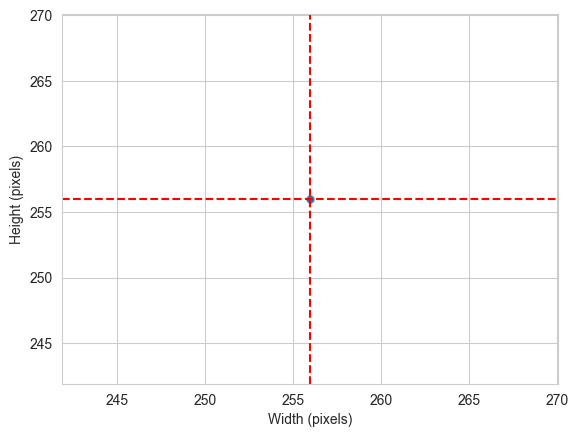

✅ Total images processed: 2944
✅ Width average: 256 
✅ Height average: 256


In [9]:
from pathlib import Path

# Lists to store image dimensions
dim1, dim2 = [], []
image_count = 0  # Initialize a counter for the number of images processed

# Iterate through each label (subdirectories in the training set)
for label in labels:
    label_path = Path(train_path) / label  # Construct label folder path

    # Iterate through each image file within the label's directory
    for image_file in label_path.iterdir():  # Directly iterate through files
        if image_file.suffix.lower() in {'.png', '.jpg', '.jpeg'}:  # Ensure only image files
            # Read the image using PIL
            img = Image.open(image_file)
            d1, d2 = img.size  # PIL returns (width, height)

            # Append the extracted dimensions to their respective lists
            dim1.append(d2)  # Store image height
            dim2.append(d1)  # Store image width

            # Increment the counter to track the number of images processed
            image_count += 1  

# Set Seaborn style for better aesthetics
sns.set_style("whitegrid")

# Create a figure and an axis for the plot
fig, axes = plt.subplots()

# Scatter plot to visualize width vs height of images
sns.scatterplot(x=dim2, y=dim1, alpha=0.2)  # Semi-transparent points for better visibility

# Label the axes
axes.set_xlabel("Width (pixels)")
axes.set_ylabel("Height (pixels)")

# Compute the mean (average) image dimensions
dim1_mean = int(np.mean(dim1))  # Average height
dim2_mean = int(np.mean(dim2))  # Average width

# Add dashed reference lines to indicate average dimensions
axes.axvline(x=dim1_mean, color='r', linestyle='--')  # Vertical line for avg width
axes.axhline(y=dim2_mean, color='r', linestyle='--')  # Horizontal line for avg height

# Display the scatter plot
plt.show()

# Print out the total number of images analyzed and the average dimensions
print(f"✅ Total images processed: {image_count}")
print(f"✅ Width average: {dim2_mean} \n✅ Height average: {dim1_mean}")

For training purposes, we should define the image shape as the average widths and heights of all the images in the train set, along with the color channels. The images in this set are all the same size (as seen from the plot above), but it is good practice to calculate the mean of each nevertheless.

In [10]:
image_shape = (dim1_mean, dim2_mean, 3)
image_shape

(256, 256, 3)

Now we save the image shape embeddings in the 'outputs' folder for later use.

In [11]:
joblib.dump(value=image_shape ,
            filename=f"{file_path}/image_shape.pkl")

print(f"📄['{file_path}']")

📄['outputs\v1']


Finally we'll confirm that the image shape stored in the .pkl file matches the image shape calculated above.

In [12]:
image_shape = joblib.load(f"{file_path}/image_shape.pkl")
print(f"Loaded image shape: {image_shape}")  # Should match expected dimensions

Loaded image shape: (256, 256, 3)


### Average and variability of images per label

Now we want to study the average variablity of images labeled 'healthy' and 'powedery_mildew' to meet the first part of business requirement 1. Let's break it down.

#### Function to load images in an array (tensor)

In [ ]:
from pathlib import Path

def load_image_as_array(my_data_dir, image_shape_pkl=None, n_images_per_label=20):
    """
    Loads image data from a specified directory, normalizes pixel values, 
    and organizes them for studying variability across labels.

    Parameters:
    - my_data_dir (str or Path): Path to the directory containing labeled subdirectories of images.
    - image_shape_pkl (str or Path): Path to a pickle file containing the desired image shape (optional).
    - n_images_per_label (int): Maximum number of images to load per label category. Default is 20.

    Returns:
    - X (numpy.ndarray): Array of processed image data with original dimensions (unless resized).
    - y (numpy.ndarray): Array of numeric labels.
    """

    my_data_dir = Path(my_data_dir)  # Ensure it is a Path object
    X, y = [], []  # Lists to store image arrays and corresponding labels
    labels = sorted([label.name for label in my_data_dir.iterdir() if label.is_dir()])  # Extract directory names

    # Create a mapping from label names to numeric indices
    label_map = {"healthy": 0, "powdery_mildew": 1}

    # Load image shape from pickle file if provided
    image_shape = None
    if image_shape_pkl:
        try:
            image_shape = joblib.load(image_shape_pkl)
            print(f"📄 Loaded image shape from pickle: {image_shape}")
        except Exception as e:
            print(f"⚠️ Error loading pickle file: {e}")

    for label in labels:
        counter = 0  # Tracks number of images processed per label
        label_path = my_data_dir / label  # Construct full path to label directory

        # Ensure the label path exists before proceeding
        if not label_path.exists():
            print(f"❌ Label path does not exist: {label_path}")
            continue

        # Iterate through image files within the label directory
        for image_file in label_path.iterdir():
            if counter >= n_images_per_label:
                break  # Stop collecting images once the limit is reached

            if image_file.suffix.lower() in {'.png', '.jpg', '.jpeg'}:  # Ensure only image files
                try:
                    # Load image while keeping original dimensions unless resizing is needed
                    img = image.load_img(image_file, target_size=image_shape[:2] if image_shape else None)  
                    img_array = image.img_to_array(img) / 255.0  # Convert to array & normalize pixel values
                    
                    X.append(img_array)  # Store processed image data
                    y.append(label_map[label])  # Assign corresponding label index
                    
                    counter += 1  # Increment counter for current label
                    
                except Exception:
                    print(f"⚠️ Skipping problematic file: {image_file}")

    # Convert lists to NumPy arrays for further statistical analysis
    X = np.array(X)
    y = np.array(y)

    # Shuffle dataset to avoid unintended biases in variability calculations
    combined = list(zip(X, y))
    random.shuffle(combined)
    X, y = zip(*combined)

    X, y = np.array(X), np.array(y)

    # Print dataset shape for reference when analyzing image variability across labels
    print(f"📄 Final shape: X={X.shape}, y={y.shape}")

    return X, y

#### Load image shapes and labels in an array

This called function will return equal numbers of images for each label as a sample. To adjust the sample size, update the n_images_per_label value and run the cell.

In [18]:
X, y = load_image_as_array(my_data_dir=train_path, 
                           image_shape_pkl=f"{file_path}/image_shape.pkl", 
                           n_images_per_label=30)

📄 Loaded image shape from pickle: (256, 256, 3)
📄 Final shape: X=(60, 256, 256, 3), y=(60,)


#### Plot and save the mean and variability of images per label

Now we'll create some images to show the average of and variability between healthy and mildewed leaves.

In [ ]:
from pathlib import Path

def plot_mean_variability_per_labels(X, y, labels, figsize=(12, 5), save_image=False, file_path=None):
    """
    Plots the mean and variability of images for each label, using dynamic label mapping.

    Parameters:
    - X (numpy.ndarray): Array of image data.
    - y (numpy.ndarray): Array of labels.
    - labels (list): List of label names corresponding to directory names.
    - figsize (tuple): Size of the figure (default: (12, 5)).
    - save_image (bool): Whether to save the generated plot (default: False).
    - file_path (str or Path): Directory path where images should be saved, required if save_image=True.

    Returns:
    - None: Displays or saves plots of average and variability images per label.
    """

    # Ensure file_path is provided if save_image is True
    if save_image:
        if file_path is None:
            raise ValueError("⚠️ Please provide a valid file path for saving images.")
        file_path = Path(file_path)  # Ensure file_path is a Path object
        file_path.mkdir(parents=True, exist_ok=True)  # Create directory if it doesn't exist

    # Create mappings between numeric labels and directory names
    label_map = {label: idx for idx, label in enumerate(labels)}
    reverse_label_map = {idx: label for label, idx in label_map.items()}  # For display purposes

    unique_labels = np.unique(y)  # Get unique numeric labels
    y = y.reshape(-1, 1)  # Reshape labels for masking consistency

    for label_to_display in unique_labels:
        sns.set_style("white")

        # Get label name dynamically
        label_name = reverse_label_map[label_to_display]

        # Create mask to filter images corresponding to the label
        boolean_mask = (y == label_to_display).reshape(-1)
        arr = X[boolean_mask]

        if arr.size == 0:
            print(f"⚠️ No images found for label '{label_name}', skipping...")
            continue

        # Compute the mean and standard deviation images
        avg_img = np.mean(arr, axis=0)
        std_img = np.std(arr, axis=0)

        # Print label details
        print(f"📄 Label '{label_name}': Image Shape = {avg_img.shape}")

        # Create a figure with two subplots
        fig, axes = plt.subplots(1, 2, figsize=figsize)
        axes[0].set_title(f"Average Image - '{label_name}'")
        axes[0].imshow(avg_img, cmap='gray')

        axes[1].set_title(f"Variability Image - '{label_name}'")
        axes[1].imshow(std_img, cmap='gray')

        # Save the plot
        if save_image:
            save_path = file_path / f"avg_var_{label_name}.png"
            plt.savefig(save_path, bbox_inches='tight', dpi=150)
            print(f"✅ Saved plot at: 📂 {save_path}")
        else:
            plt.tight_layout()
            plt.show()

        print("\n")

Call the function to see the plots...

📄 Label 'healthy': Image Shape = (256, 256, 3)
✅ Saved plot at: 📂 outputs\v1\avg_var_healthy.png


📄 Label 'powdery_mildew': Image Shape = (256, 256, 3)
✅ Saved plot at: 📂 outputs\v1\avg_var_powdery_mildew.png




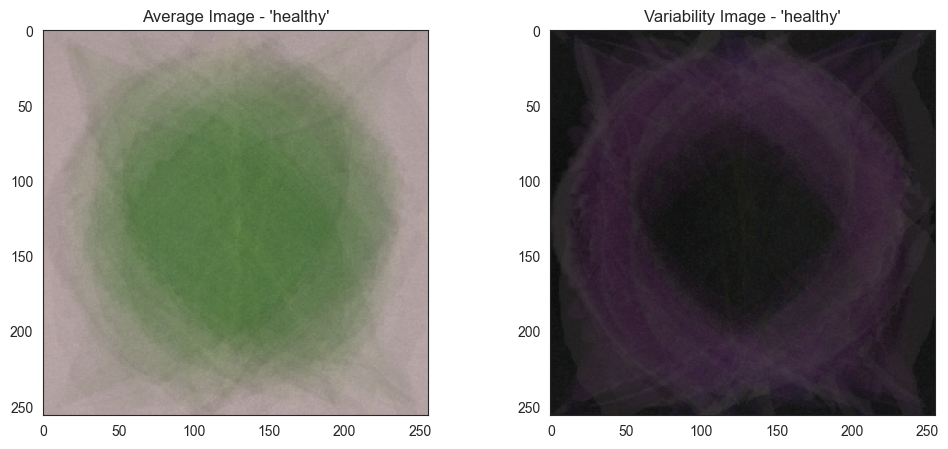

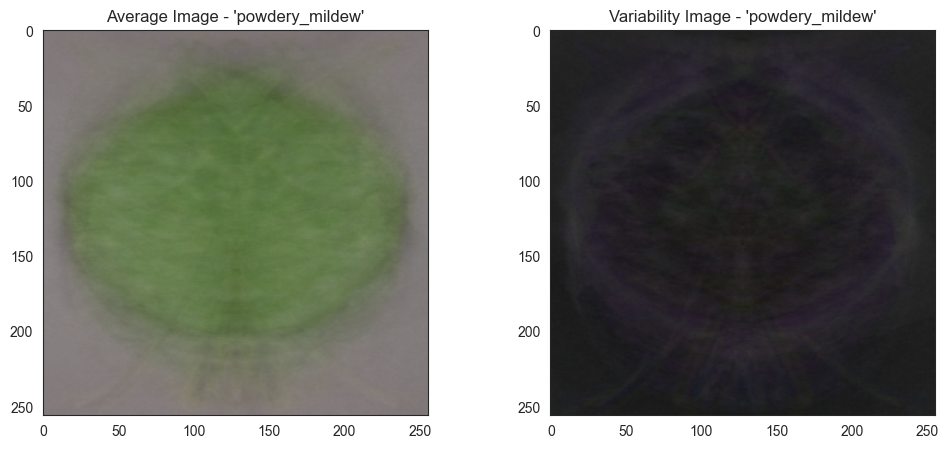

In [20]:
plot_mean_variability_per_labels(X=X, y=y, labels=labels, figsize=(12, 5), save_image=True, file_path=file_path)

Excellent! Now we have satisfied the first part of business requirement 1! Let's move on to the next part.

### Difference between average parasite-contained and average uninfected cell images

We will now create a function to study the difference betwen average healthy leaves and average mildewed leaves. This will help us to satisfy the second part of business objective 1.

First we need a function to extract the images for each label and put them into an array...

In [23]:
from pathlib import Path

def subset_image_label(X, y, label_to_display):
    """
    Extracts images corresponding to a specific label and returns a NumPy array.

    Parameters:
    - X: NumPy array containing image data
    - y: NumPy array containing labels corresponding to images
    - label_to_display: The target label (integer) to filter images

    Returns:
    - NumPy array of images that match the given label
    """
    y = y.reshape(-1, 1, 1)  # Ensure proper shape for comparison
    boolean_mask = np.any(y == label_to_display, axis=1).reshape(-1)  # Create a boolean mask
    return X[boolean_mask]  # Filter images based on label


... then a function to compare the average images in that array.

In [ ]:
def diff_bet_avg_image_labels_data_as_array(X, y, labels, figsize=(20, 5), save_image=False, file_path=None):
    """
    Compares the average images between the labels in the dataset and visualizes their differences.

    Parameters:
    - X: NumPy array of image data
    - y: NumPy array of labels
    - labels: List of label names retrieved from directory structure
    - figsize: Tuple specifying figure size for visualization
    - save_image: Boolean flag to determine if the plot should be saved
    - file_path: Directory path where the saved image should be stored (if `save_image=True`)

    Outputs:
    - Displays the average images for both labels and their difference.
    - Saves the visualization to a file if `save_image=True`.
    """

    sns.set_style("white")  # Set visual styling for the plots

    # Ensure there are at least two labels to compare
    if len(labels) < 2:
        print("❌ Error: Not enough labels in dataset to compare.")
        return

    label_1, label_2 = labels[:2]  # Select first two labels dynamically

    # Create mapping from label names to numerical indices
    label_mapping = {label: i for i, label in enumerate(labels)}

    # Convert label names to numerical indices
    label_1_num = label_mapping[label_1]
    label_2_num = label_mapping[label_2]

    # Validate that the requested labels exist in the dataset
    unique_labels = np.unique(y)
    if label_1_num not in unique_labels or label_2_num not in unique_labels:
        print(f"❌ Error: Either label '{label_1}' or '{label_2}' is not present in {unique_labels}")
        return

    # Compute the average pixel values for images belonging to each label
    label1_avg = np.mean(subset_image_label(X, y, label_1_num), axis=0)
    label2_avg = np.mean(subset_image_label(X, y, label_2_num), axis=0)
    difference_mean = label1_avg - label2_avg  # Compute pixel-wise difference

    # Create a figure with three subplots for visualization
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=figsize)
    titles = [
        f"average '{label_1}'",  # Title for first label's average image
        f"average '{label_2}'",  # Title for second label's average image
        f"difference: '{label_1}' - '{label_2}'",  # Title for difference between the two images
    ]
    images = [label1_avg, label2_avg, difference_mean]

    # Loop through the plots to display images with appropriate titles
    for ax, img, title in zip(axes, images, titles):
        ax.imshow(img, cmap='gray')  # Display images in grayscale
        ax.set_title(title)  # Set title for each subplot
        ax.axis("off")  # Hide axis labels for a cleaner look

    # Save the plot or show if save_image is set to false
    if save_image:
        if file_path is None:
            raise ValueError("⚠️ Please provide a valid file path for saving images.")
        file_path = Path(file_path)  # Ensure file_path is a Path object
        file_path.mkdir(parents=True, exist_ok=True)  # Create directory if it doesn't exist
        save_path = file_path / f"avg_diff_{label_1}_{label_2}.png"
        plt.savefig(save_path, bbox_inches="tight", dpi=150)
        print(f"✅ Saved plot at: 📂 {save_path}")
    else:
        plt.tight_layout()
        plt.show()

Now call the above function.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


✅ Saved plot at: 📂 outputs\v1\avg_diff_healthy_powdery_mildew.png


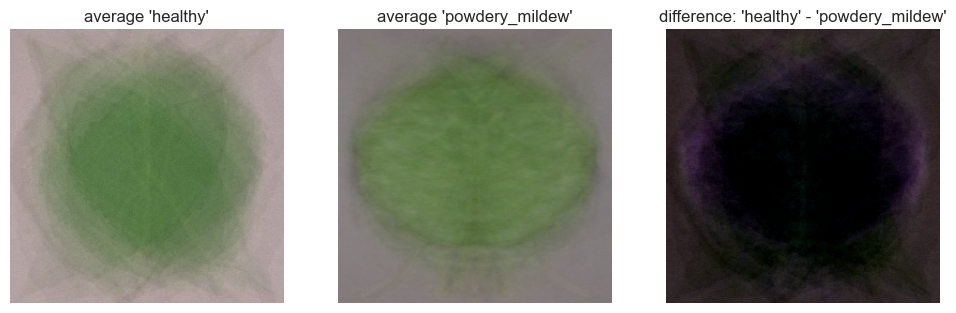

In [24]:
diff_bet_avg_image_labels_data_as_array(X=X, y=y,
                                        labels=labels,
                                        figsize=(12, 10),
                                        save_image=True,
                                        file_path=file_path
                                        )

Good! We have now tackled the second part of business requiremenmt 1! Let's push on to the final step of data visualization, the image montage!

### Image montage

OK, now we need to create an image montage to satisfy the last element of the customer's business requirement 1. Let's create another function for that.

In [25]:
from pathlib import Path

def create_image_montage(images, labels=None, labels_list=None, rows=3, cols=3, figsize=(10, 10), cmap='gray', save_image=False, file_path=None):
    """
    Creates an image montage displaying a grid of images for easy comparison.

    Parameters:
    - images: NumPy array containing image data
    - labels: NumPy array of numerical labels corresponding to each image (optional)
    - labels_list: List of label names that map numerical labels to actual class names (optional)
    - rows: Number of rows in the montage (default: 3)
    - cols: Number of columns in the montage (default: 3)
    - figsize: Tuple specifying figure size (default: (10, 10))
    - cmap: Color map for displaying images (default: 'gray' for grayscale)
    - save_image: Boolean flag to determine whether to save the montage (default: False)
    - file_path: Path where the saved image should be stored (if `save_image=True`)

    Outputs:
    - Displays an image montage with optional class names as titles.
    - Saves the montage as a file if `save_image=True`.
    """

    num_images = len(images)  # Get total number of images
    montage_size = rows * cols  # Compute total number of images to display

    # Ensure we do not exceed available images
    selected_images = images[:montage_size]  # Slice the image array to match montage size
    if labels is not None:
        selected_labels = labels[:montage_size]  # Slice label array if labels exist

    # Create a figure with grid layout
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten()  # Convert grid into a single list for easy iteration

    # Loop through each subplot
    for i, ax in enumerate(axes):
        if i < num_images:
            img = selected_images[i]  # Get the image to display
            ax.imshow(img, cmap=cmap)  # Display the image with specified colormap
            ax.axis("off")  # Hide axis labels for cleaner visualization
            
            # If labels exist, display corresponding class names
            if labels is not None and labels_list is not None:
                label_index = selected_labels[i]  # Retrieve numerical label
                ax.set_title(f"'{labels_list[label_index]}'", fontsize=10)  # Map label index to actual name

    plt.tight_layout()  # Adjust spacing between images

    # Save or display the montage
    if save_image:
        if file_path is None:
            raise ValueError("⚠️ Please provide a valid file path for saving images.")
        
        file_path = file_path if isinstance(file_path, Path) else Path(file_path)  # Ensure Path object
        
        if not file_path.exists():
            file_path.mkdir(parents=True, exist_ok=True)  # Create directory if missing
        
        save_path = file_path / "image_montage.png"
        plt.savefig(save_path, bbox_inches="tight", dpi=150)
        print(f"✅ Saved montage at: 📂 {save_path}")
    else:
        plt.show()  # Display the montage

Call the function...

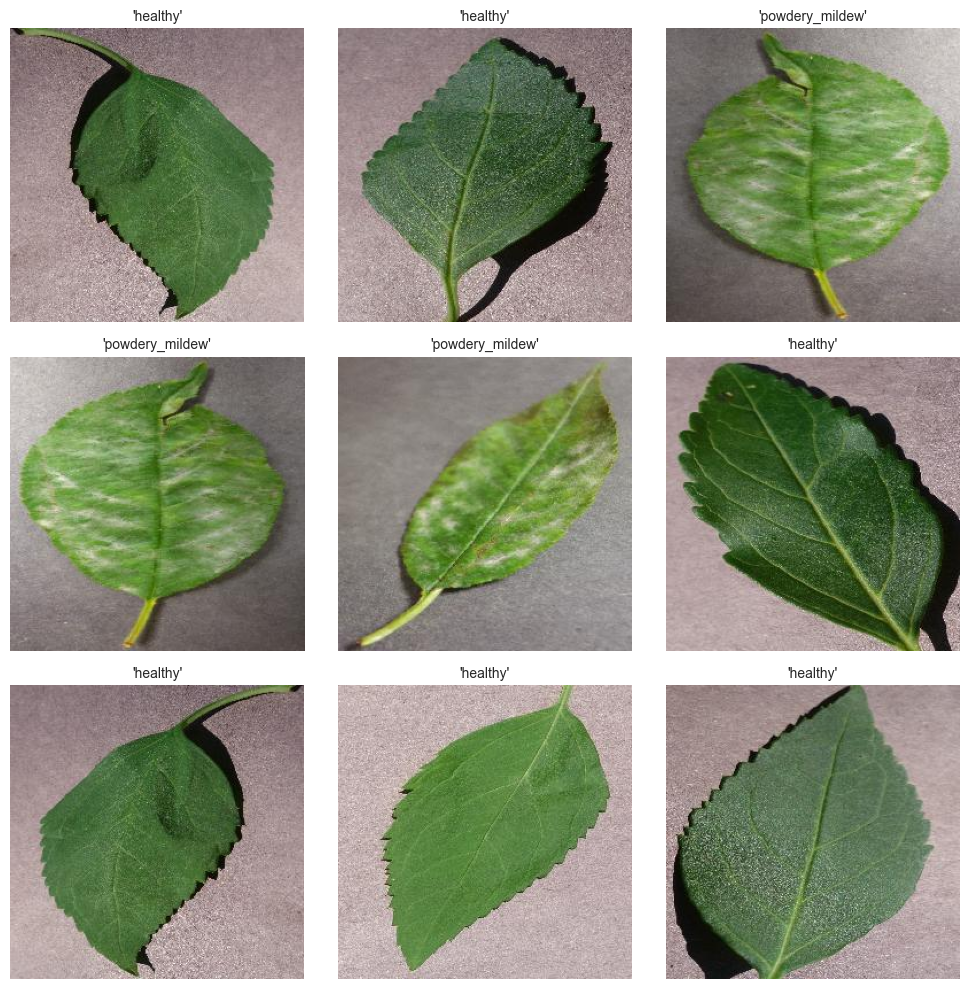

In [26]:
create_image_montage(images=X, labels=y, labels_list=labels, rows=3, cols=3)

Done! Business requirement 1 is now fully satisfied!

## Summary

Well that was a lot of good work for business requirement 1! In this notebook we:

- Set our downloaded image directories as the source of out data
- Set and then checked that we had defined the right file paths for accessing the image data
- Set up an 'output' directory for our upcoming files
- Set the labels for our images as either 'healthy' or 'powdery_mildew'
- Calculated the average image shap (dimensions) and saved that shape in a .pkl file for later use
- Studied the average variability of images for each label
- Studied the difference between average 'healthy' images and 'powderdy_mildew' images
- Created an image montage

Well done! Take a breather and when you're ready, lets move on to the next notebook where we will develop, fit and evaluate a training model!